In [1]:
!rm -r *
!git clone https://github.com/uel/BP
!mv -v BP/* .
!rm -r BP

Cloning into 'BP'...
remote: Enumerating objects: 1019, done.
remote: Counting objects: 100% (1019/1019), done.
remote: Compressing objects: 100% (1009/1009), done.
remote: Total 1019 (delta 11), reused 1010 (delta 8), pack-reused 0
Receiving objects: 100% (1019/1019), 21.60 MiB | 16.27 MiB/s, done.
Resolving deltas: 100% (11/11), done.
renamed 'BP/data' -> './data'
renamed 'BP/data.py' -> './data.py'
renamed 'BP/keys.py' -> './keys.py'
renamed 'BP/main.py' -> './main.py'
renamed 'BP/notebooks' -> './notebooks'
renamed 'BP/__pycache__' -> './__pycache__'
renamed 'BP/template' -> './template'
renamed 'BP/tests.py' -> './tests.py'
renamed 'BP/video_download.py' -> './video_download.py'


In [2]:
import os
import cv2
import numpy as np
from data import GetPointsFromXML
import matplotlib.pyplot as plt
import albumentations as A
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import random

In [3]:
def preprocess_image(image, inverse_mappping=False):
    # Resize image while maintaining the aspect ratio
    target_height = 360
    aspect_ratio = image.shape[1] / image.shape[0]
    target_width = int(target_height * aspect_ratio)

    if target_width > 640:
        target_width = 640
        target_height = int(target_width / aspect_ratio)

    resized_image = cv2.resize(image, (target_width, target_height))
    resize_ratio = target_width / image.shape[1]

    # Place the resized image on a black background
    background = np.zeros((360, 640, 3), dtype=np.uint8)
    x_offset = (640 - target_width) // 2
    y_offset = (360 - target_height) // 2
    background[y_offset:y_offset+target_height, x_offset:x_offset+target_width] = resized_image

    # Normalize pixel values between 0 and 1
    normalized_image = background / 255.0

    # Create function for coordinate mapping
    if inverse_mappping:
        map_coordinates = lambda x, y: ( (x*640 - x_offset)/resize_ratio, (y*360 - y_offset)/resize_ratio )
    else:
        map_coordinates = lambda x, y: ( (x*resize_ratio + x_offset) / 640, (y*resize_ratio + y_offset) / 360 )

    return normalized_image, map_coordinates


In [4]:
def AugmentImage(image, bounding_box=[], n=4):
    transform = A.Compose([
        A.RandomBrightnessContrast(p=1, brightness_limit=0.2, contrast_limit=0.2),
        A.ShiftScaleRotate(p=1, border_mode=cv2.BORDER_CONSTANT, rotate_limit=3, scale_limit=0.1, shift_limit=0.1),
    ], keypoint_params=A.KeypointParams(format='xy', remove_invisible=True))

    if bounding_box != []:
      bounding_box = bounding_box.copy()
      bounding_box[:,0]*=639.9
      bounding_box[:,1]*=359.9

    image = (image * 255).astype(np.uint8)

    augmented_images = []
    bounding_boxes = []

    # Generate n augmentations
    while len(augmented_images) < n:
        # Apply the transformation to the image
        augmented = transform(image=image, keypoints=bounding_box)
        img = augmented['image']
        b_box = augmented['keypoints']

        # Append the augmented image and bounding box coordinates to the result
        if len(b_box) == len(bounding_box):
            augmented_images.append(img.astype(float)/255.)
            b_box = np.array(b_box, dtype=float)
            b_box[:, 0] = b_box[:, 0]/639.9
            b_box[:, 1] = b_box[:, 1]/359.9
            bounding_boxes.append(b_box)

    return augmented_images, bounding_boxes

In [5]:
def GetData(dir, files=[], points=None, augument_data=False):

    if len(files) == 0:
        files = os.listdir(dir)

    points_res = []
    images = []
    for file in files:
        img = cv2.imread(dir +"/"+ file)
        normalized_image, map_coordinates = preprocess_image(img)
        images.append(normalized_image)
        if points is not None:
            mapped_points = np.array([map_coordinates(x, y) for (x, y) in points[files.index(file)]])
            points_res.append(mapped_points)

        if augument_data:
          if points is not None:
            aug_imgs, aug_points = AugmentImage(normalized_image, mapped_points)
            for i, aug_img in enumerate(aug_imgs):
              images.append(aug_img)
              points_res.append(aug_points[i])

          else:
            aug_imgs, _ = AugmentImage(normalized_image)
            for aug_img in aug_imgs:
              normalized_image, _ = preprocess_image(aug_img)
              images.append(normalized_image)

    if points is not None:
        return np.array(images), np.array(points_res).reshape((len(points_res),8))
    return np.array(images)


In [6]:
def GetDetectionData():
    with_keyboard = LoadImages("data/separated_frames/with_keyboard")
    without_keyboard = LoadImages("data/separated_frames/without_keyboard")
    min_class_count = min(len(with_keyboard), len(without_keyboard))
    combined = np.array(with_keyboard[:min_class_count] + without_keyboard[:min_class_count])
    labels = np.array([1.]*(min_class_count) + [0.]*(min_class_count))

    return train_test_split(combined, labels, test_size=0.3, shuffle=false)

In [7]:
def TrainDetectionModel(x_train, x_test, y_train, y_test):
    detection = Sequential()
    detection.add(Conv2D(32, (3, 3), activation='relu', input_shape=(360, 640, 3)))
    detection.add(MaxPooling2D((2, 2)))
    detection.add(Conv2D(64, (3, 3), activation='relu'))
    detection.add(MaxPooling2D((2, 2)))
    detection.add(Flatten())
    detection.add(Dense(64, activation='relu'))
    detection.add(Dense(1, activation='sigmoid'))
    detection.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    detection.fit(x_train, y_train, epochs=3, validation_data=(x_test, y_test), batch_size=4)
    detection.save("models/detection.h5")
    return detection

In [8]:
# display n randomly sampled images in notebook, images can be list or array, can be gray scale or rgb
def DisplaySample(images, n, points=[]):
    if isinstance(images, list):
        sampled_indices = random.sample(range(len(images)), n)
    else:
        sampled_indices = random.sample(range(images.shape[0]), n)

    for i in range(n):
        plt.figure()

        image = images[sampled_indices[i]]

        if points != []:
          p = points[sampled_indices[i]]
          p = p.reshape((4, 2))
          p[:, 0] *= 639
          p[:, 1] *= 359
          p = p.astype(int)
          for (x, y) in p:
            cv2.circle(image, (x, y), 5, (0, 255, 0), -1)

        if len(image.shape) == 2:
            plt.imshow(image, cmap='gray')
        else:
            plt.imshow(image[...,::-1])

        plt.axis('off')
        plt.show()


<ipython-input-4-96d68f42f8da>:7: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bounding_box != []:


(505, 8) 0.0 1.0001532344330961


<ipython-input-8-424f5f7faa3d>:13: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if points != []:


(505, 360, 640, 3) 0.0 1.0


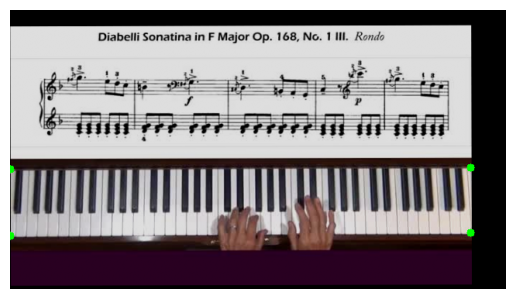

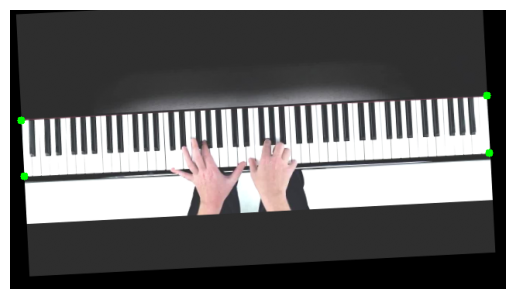

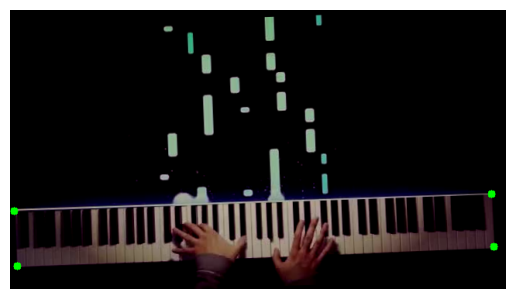

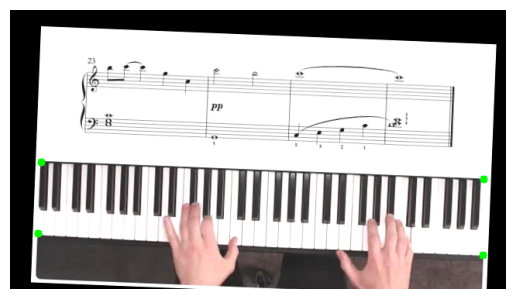

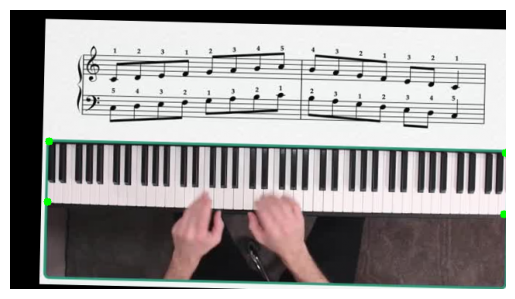

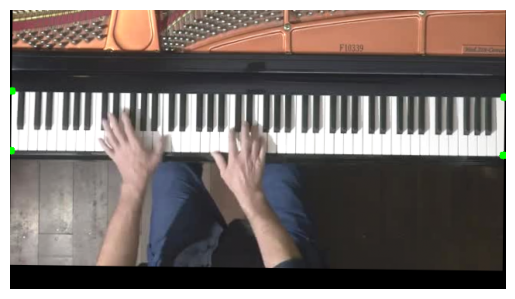

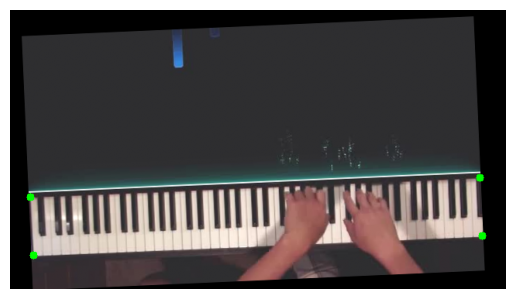

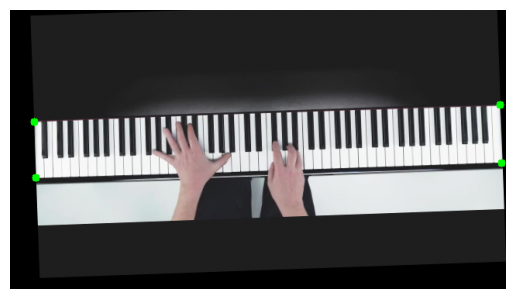

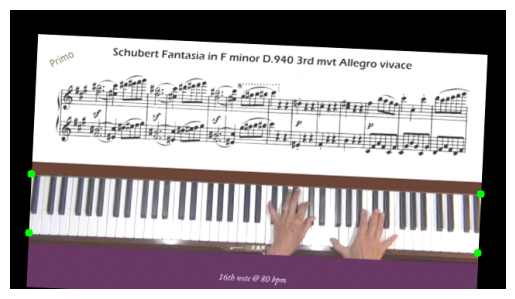

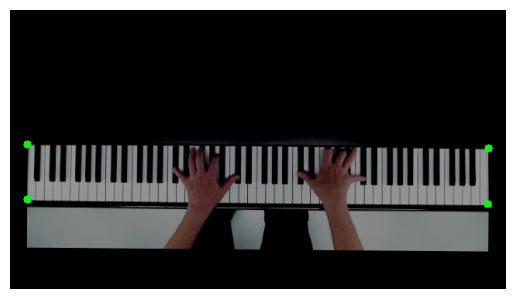

In [9]:
points, images = GetPointsFromXML("data/separated_frames/keyboard_annotations.xml")
images, points = GetData("data/separated_frames/with_keyboard", images, points, True)
print(points.shape, points.min(), points.max())
print(images.shape, images.min(), images.max())
DisplaySample(images, 10, points)

In [10]:
def TrainBoundingBoxModel(model_name, images, points, grayscale=False):
    bounding_box = Sequential()
    if grayscale: bounding_box.add(Conv2D(32, (3, 3), activation='relu', input_shape=(360, 640, 1)))
    else: bounding_box.add(Conv2D(32, (3, 3), activation='relu', input_shape=(360, 640, 3)))
    bounding_box.add(MaxPooling2D((2, 2)))
    bounding_box.add(Conv2D(64, (3, 3), activation='relu'))
    bounding_box.add(MaxPooling2D((2, 2)))
    bounding_box.add(Flatten())
    bounding_box.add(Dense(64, activation='relu'))
    bounding_box.add(Dense(8, activation='sigmoid'))
    bounding_box.compile(optimizer='adam', loss='mean_squared_error')

    # try: bounding_box = load_model("models/" + model_name + ".h5")
    # except: pass

    x_train, x_test, y_train, y_test = train_test_split(images, points, test_size=0.5, shuffle=True)
    print(x_train)

    print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

    bounding_box.fit(x_train, y_train, epochs=8, validation_data=(x_test, y_test), batch_size=8)
    bounding_box.save("models/" + model_name + ".h5")

    return bounding_box

In [11]:
TrainBoundingBoxModel("bounding_box", images, points)

[[[[0.03137255 0.02352941 0.02352941]
   [0.03137255 0.02352941 0.02352941]
   [0.03137255 0.02352941 0.02352941]
   ...
   [0.03137255 0.02352941 0.02352941]
   [0.03137255 0.02352941 0.02352941]
   [0.03137255 0.02352941 0.02352941]]

  [[0.03137255 0.02352941 0.02352941]
   [0.03137255 0.02352941 0.02352941]
   [0.03137255 0.02352941 0.02352941]
   ...
   [0.03137255 0.02352941 0.02352941]
   [0.03137255 0.02352941 0.02352941]
   [0.03137255 0.02352941 0.02352941]]

  [[0.03137255 0.02352941 0.02352941]
   [0.03137255 0.02352941 0.02352941]
   [0.03137255 0.02352941 0.02352941]
   ...
   [0.03137255 0.02352941 0.02352941]
   [0.03137255 0.02352941 0.02352941]
   [0.03137255 0.02352941 0.02352941]]

  ...

  [[0.03137255 0.01568627 0.0627451 ]
   [0.03137255 0.01568627 0.0627451 ]
   [0.03137255 0.01568627 0.0627451 ]
   ...
   [0.03137255 0.02352941 0.02352941]
   [0.03137255 0.02352941 0.02352941]
   [0.03137255 0.02352941 0.02352941]]

  [[0.03137255 0.01568627 0.0627451 ]
   [0.0